In [1]:
%pylab inline
import numpy as np
import cPickle as pickle
import pandas as pd
import seaborn as sns
import time
import sys
sys.path.append("../")
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [2]:
infile_neurons = "../data/medulla.neurondf.pickle"
infile_synapses = "../data/medulla.synapsesdf.pickle"

n = pickle.load(open(infile_neurons, 'r'))
s = pickle.load(open(infile_synapses, 'r'))

neurondf = n['neurondf']
neurondf_subset = neurondf.dropna(subset=['name']).copy() # drop all unnamed cells
neurondf_subset['idx'] = np.arange(len(neurondf_subset))
neurondf_subset.index = neurondf_subset['body ID']
neurondf_subset['matrixpos'] = np.arange(len(neurondf_subset))
print "len(neurondf_subset)", len(neurondf_subset)

tbar_df = s['tbar_df']
valid_tbar_df = tbar_df[tbar_df['body ID'].isin(neurondf_subset.index.values)].copy()
valid_tbar_df['matrixpos'] = np.arange(len(valid_tbar_df))
connections_df = s['connections_df']
connections_df.head()
valid_connections_df =connections_df[connections_df['body ID'].isin(neurondf_subset.index.values)] 

len(neurondf_subset) 908


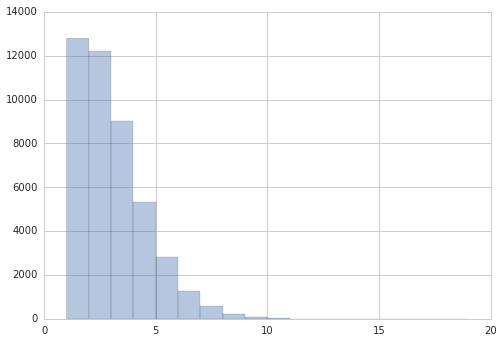

In [3]:
sns.distplot(valid_connections_df.groupby('tbar_id').size(), 
             bins=np.arange(1, 20), kde=False)


In [4]:
valid_neuron_n = len(neurondf_subset)
valid_tbar_n = len(valid_tbar_df)
print "valid_tbar_n=", valid_tbar_n
valid_partners_n = len(valid_connections_df)
print "valid partners n =", valid_partners_n

valid_tbar_n= 37452
valid partners n = 114151


In [5]:
neurondf_subset.head()
mdf = pd.merge(valid_tbar_df, neurondf_subset, on='body ID')
mdf.head()

body ID  confidence flagged  id  loc_x  loc_y  loc_z multi status_x  \
0     4270           1     NaN   0   3829   3674   1006   NaN  working   
1     4270           1     NaN   1   3871   3657   1012   NaN  working   
2     4270           1     NaN   2   3878   3589   1065   NaN  working   
3     4270           1     NaN   3   3675   2918   1171   NaN  working   
4     4270           1     NaN   9   3318   2701   1298   NaN  working   

   matrixpos_x  anchor cell type            comment location  name   status_y  \
0            0  anchor       NaN  tangential (auto)      NaN  C2-F  corrected   
1            1  anchor       NaN  tangential (auto)      NaN  C2-F  corrected   
2            2  anchor       NaN  tangential (auto)      NaN  C2-F  corrected   
3            3  anchor       NaN  tangential (auto)      NaN  C2-F  corrected   
4            9  anchor       NaN  tangential (auto)      NaN  C2-F  corrected   

   idx  matrixpos_y  
0   49           49  
1   49           49  
2   49           49  
3   49           49  
4   49           49

(0, 908)

/opt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


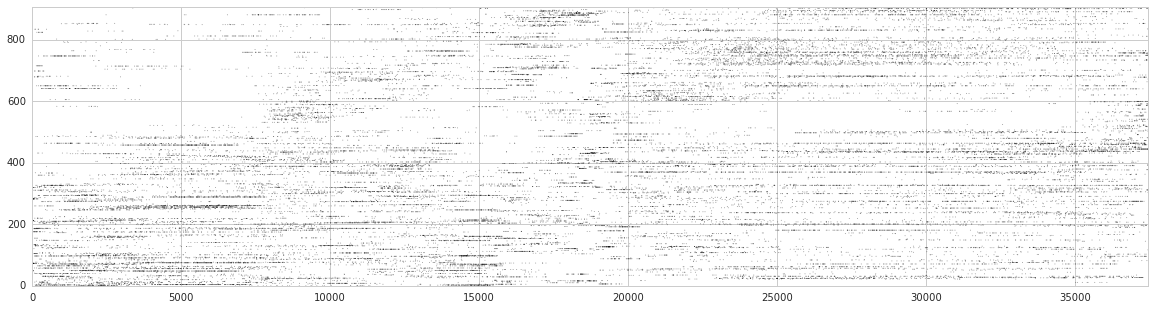

In [6]:
# construct the first pass of partner by tbar matrix
pre_mx = np.array(mdf['matrixpos_x'])
pre_my = np.array(mdf['matrixpos_y'])
#M[my, mx] +=1     
pylab.figure(figsize=(20, 5))
#pylab.imshow(M, interpolation='nearest', cmap=pylab.cm.gray_r, aspect=12)
pylab.scatter(pre_mx, pre_my, edgecolor='none', s=1, c='k', alpha=0.4)
pylab.xlim(0, valid_tbar_n)
pylab.ylim(0, valid_neuron_n)

In [7]:
neurondf_subset.head()
mdf = pd.merge(valid_connections_df, neurondf_subset, on='body ID')
mdf.head()
mdf['neuron_post_matrixpos'] = mdf['matrixpos']
mdf = mdf.join(valid_tbar_df, on='tbar_id', rsuffix='_tbar')
mdf['tbar_post_matrixpos'] = mdf['matrixpos_tbar']
mdf = mdf.dropna(subset = ['neuron_post_matrixpos', 'tbar_post_matrixpos'])
post_mx = np.array(mdf.tbar_post_matrixpos).astype(int)
post_my = np.array(mdf.neuron_post_matrixpos).astype(int)
#mdf.head()
    

(0, 908)

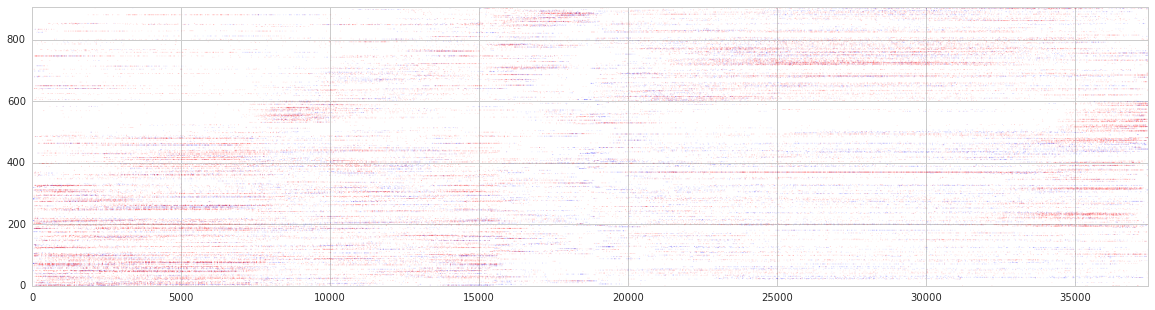

In [8]:

pylab.figure(figsize=(20, 5))
#pylab.imshow(M, interpolation='nearest', cmap=pylab.cm.gray_r, aspect=12)
pylab.scatter(pre_mx, pre_my, edgecolor='none', s=1, c='b', alpha=0.1)
pylab.scatter(post_mx, post_my, edgecolor='none', s=1, c='r', alpha=0.1)

pylab.xlim(0, valid_tbar_n)
pylab.ylim(0, valid_neuron_n)

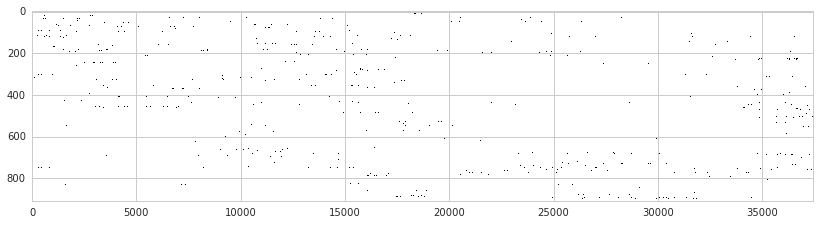

In [9]:
M = np.zeros((valid_neuron_n, valid_tbar_n))
M[pre_my, pre_mx] = 1
M[post_my, post_mx] = 1
pylab.figure(figsize=(14, 4))
pylab.imshow(M, aspect=10, interpolation='nearest')
pylab.savefig('foo.png', dpi=300)

In [10]:
# empirical bayes of params
print float(np.sum(M==1))/np.sum(M==0) * 100, "% nonzero"

0.356484560604 % nonzero


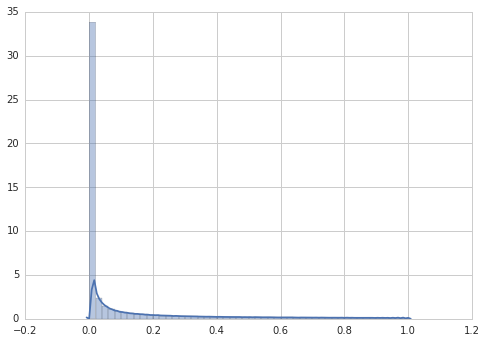

In [11]:
sns.distplot(np.random.beta(0.1, 1.0, 1000000))

In [ ]:
def default_kernel_anneal(start_temp = 32.0, iterations=100, enable_relation=True):
    dk = irm.runner.default_kernel_nonconj_config()
    dk =  irm.runner.add_domain_hp_grid_kernel(dk)
    if enable_relation:
        dk =  irm.runner.add_relation_hp_grid_kernel(dk)
    
    return [('anneal', {'anneal_sched': {'start_temp' : start_temp, 
                                         'stop_temp' : 1.0, 
                                         'iterations' : iterations}, 
                         'subkernels': dk})]


In [17]:
pickle.dump(M, open("../bipartite.M.pickle", 'w'), -1)

In [15]:
import irm
import cvpipelineutil
reload(cvpipelineutil)
conmat = (M > 0).astype(np.uint8)
np.random.seed(0)
NEURON_N = 1000
TBAR_N = 100000

neuron_idx = np.random.permutation(conmat.shape[0])[:NEURON_N]
tbar_idx = np.random.permutation(conmat.shape[1])[:TBAR_N]
conmat_sub = conmat[neuron_idx]
conmat_sub = conmat_sub[:, tbar_idx]
T1_N = conmat_sub.shape[0]
T2_N = conmat_sub .shape[1]



model_name = "BetaBernoulli"

init_latent = {'domains' : {'d1' : {'hps' : {'alpha' : 1.0},
                               'assignment' : np.arange(T1_N) % 50} , 
                       'd2' : {'hps' : {'alpha' : 1.0},
                               'assignment' : np.arange(T2_N) % 50} , 
                       
                       },
          'relations' : { 'R1' : {'hps' : {'alpha' : 1.0, 
                                           'beta' : 1.0}}}}

data = {'domains' : {'d1' : {  'N' : T1_N},
                     'd2' : { 'N': T2_N }}, 
        'relations' : { 'R1' : {'relation' : ('d1', 'd2'), 
                                'model' : model_name, 
                                'data' : conmat_sub}}}





init_latent['domains']['d1']['assignment'] = np.random.permutation(T1_N) % 100
init_latent['domains']['d2']['assignment'] = np.random.permutation(T2_N) % 100


HPS = {'alpha' : 0.1, 'beta' : 5.0}

init_latent['relations']['R1']['hps'] = HPS

TOTAL_ITERS = 100
slow_anneal = default_kernel_anneal(iterations=int(TOTAL_ITERS * 0.75), enable_relation=False)

kc ={'ITERS' : TOTAL_ITERS, 
    'kernels' : slow_anneal}
t1 = time.time()
s = cvpipelineutil.run_exp_pure(data, init_latent, 'anneal_slow_10', 0, kc)
t2 = time.time()
print "total time", t2-t1

Running with 8 cores
Creating threadpool with 8 cores
FIXED_K= False
Running with relation_class= <class 'irm.pyirmutil.ParRelation'>
This model fixed_k=  False
This model fixed_k=  False
Annealing at temp= 32.0


RuntimeError: too many groups!

In [ ]:
res = s['res']
scores, state, times, _ = res

a1 = irm.util.canonicalize_assignment(state['domains']['d1']['assignment'])
ca1 = np.argsort(a1).flatten()

a2 = irm.util.canonicalize_assignment(state['domains']['d2']['assignment'])
ca2 = np.argsort(a2).flatten()

conmat_sorted = conmat_sub[ca1]
conmat_sorted = conmat_sorted[:, ca2]

In [ ]:
state['relations']['R1']['hps']

In [ ]:
pylab.figure(figsize=(16, 6))
pylab.imshow(conmat_sorted, interpolation='nearest')
pylab.grid(False)
pylab.ylabel('e_i')
pylab.xlabel('e_j')
pylab.title("e_i tries to talk to e_j")
pos = np.argwhere(np.diff(a1[ca1]))
print len(pos )
for p in pos:
    pylab.axhline(p, c='b', alpha=0.2)
pos = np.argwhere(np.diff(a2[ca2]))
print len(pos)
for p in pos:    
    pylab.axvline(p, c='b', alpha=0.2)
#pylab.xticks([])
#pylab.yticks([])
#pylab.ylim(600, 950)
pylab.grid(False)